# Detecting temperature targets
##### authors: Elizabeth A. Barnes and Noah Diffenbaugh
##### date: March 14, 2022 15:14 Mountain Time

##### README:

* All user-defined parameters (other than plotting colors etc) are defined in the top cell called "User-defined Experiment Parameters". Most of your edits should just be there.
* The code will train either a typical regression problem ```reg``` or it will predict the conditional normal distribution ```shash2```
* The code provides the option of saving the tensorflow models (and their metadata) so that you can load them later and make predictions. This may be particularly useful if you find a good model that you like (and don't want to retrain over and over again) or if you want to save ~50 models and then use them to predict the observational fields to make a distribution of uncertainty (like I did in the google slides)
* The random seed calls should be written so that everything is exactly reproducible. So, run the same code tomorrow and you should get identical answers.
* Just a note that unfortunately Colaboratory is really slow for the ```shash2``` model (~20+ min!). I am happy to train models for us on my awesome M1 chip laptop when the time comes, but I figured you want to play from start to finish. The good news though is that the parameters I have below are already pretty good ones!


## User-defined Experiment Parameters

In [1]:
exp_settings = {
    "exp_name": 'test',
    "save_model": True,
    "n_models": 1,                        # the number of networks you want to train (via a loop)
    "ssp" : "370",                        #[options: '126' or '370']
    "target_temp": 1.5,
    "n_train_val_test" : (7,3,0),
    "baseline_yr_bounds": (1850,1899),
    "training_yr_bounds": (1970,2100),
    "anomaly_yr_bounds": (1951,1980),
    "anomalies": True,                    #[options: True or False]
    "remove_map_mean": False,             #[options: False or "weighted" or "raw"]
    "show_plots" : False,                 #[options: False or True]

    "network_type": 'reg',                #[options: "reg" or "shash2"]
    "hiddens": [10,10],
    "dropout_rate": 0.,
    "ridge_param": [1.5,0.0], 
    "learning_rate": 0.00005,
    "batch_size": 64,
    "rng_seed": 8889,
    "act_fun": ["relu","relu"],
    "n_epochs": 25_000,
    "patience": 50,
    "verbosity": 0,
}

## Python setup

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

IN_COLAB = False


In [3]:
if IN_COLAB:
    !pip install xarray==0.20.2
    !pip install nc-time-axis

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Softmax
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow import keras

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [4]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")  
print(f"tensorflow version = {tf.__version__}")  
print(f"tensorflow-probability version = {tfp.__version__}")  

python version = 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:27:43) 
[Clang 11.1.0 ]
numpy version = 1.22.2
xarray version = 2022.3.0
tensorflow version = 2.7.0
tensorflow-probability version = 0.15.0


## Data functions

In [5]:
if exp_settings["ssp"] == '370':
    filenames = ('tas_Amon_historical_ssp370_CanESM5_r1-10_ncecat_ann_mean_2pt5degree.nc',
                 'tas_Amon_historical_ssp370_GISS-E2-1-G_r1-10_ncecat_ann_mean_2pt5degree.nc',
                 'tas_Amon_historical_ssp370_IPSL-CM6A-LR_r1-10_ncecat_ann_mean_2pt5degree.nc',
                 'tas_Amon_historical_ssp370_UKESM1-0-LL_r1-10_ncecat_ann_mean_2pt5degree.nc',
                 'tas_Amon_historical_ssp370_ACCESS-ESM1-5_r1-10_ncecat_ann_mean_2pt5degree.nc',
                )
elif exp_settings["ssp"] == '126':
    filenames = ('tas_Amon_historical_ssp126_CanESM5_r1-10_ncecat_ann_mean_2pt5degree.nc',
                 'tas_Amon_historical_ssp126_MIROC6_r1-10_ncecat_ann_mean_2pt5degree.nc',
                 'tas_Amon_historical_ssp126_ACCESS-ESM1-5_r1-10_ncecat_ann_mean_2pt5degree.nc',
                 'tas_Amon_historical_ssp126_UKESM1-0-LL_r1-10_ncecat_ann_mean_2pt5degree.nc',
            )
else:
    raise NotImplementedError('no such SSP')

N_GCMS = len(filenames)


In [6]:
DATA_DIRECTORY = 'data/'

def save_tf_model(model, model_name):
    
    import json
    
    if IN_COLAB:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
        MODEL_DIRECTORY = '/content/drive/MyDrive/Colab Notebooks/'
        # raise ValueError('@Noah - please set the GoogleDrive model_path above where you want to save things')
    else:
        MODEL_DIRECTORY = 'saved_models/'        

    # save the tf model
    tf.keras.models.save_model(model, MODEL_DIRECTORY + model_name + "_model", overwrite=True)

    # save the meta data
    save_exp_settings = exp_settings.copy()
    save_exp_settings['random_seed'] = int(SEED)
    save_exp_settings['train_members'] = train_members.tolist()
    save_exp_settings['val_members'] = val_members.tolist()
    save_exp_settings['test_members'] = test_members.tolist()
    with open(MODEL_DIRECTORY + model_name + '_metadata.json', 'w') as json_file:
        json_file.write(json.dumps(save_exp_settings))
        
    # example code for loading a tf model
    # model = tf.keras.models.load_model(MODEL_DIRECTORY + model_name + "_model", compile = False)
    # predictions = model.predict(x_data)
        
def get_netcdf_da(filename):
    if IN_COLAB:
        !pip install wget
        import wget
        nc_file = wget.download("https://eabarnes-data.atmos.colostate.edu/share/" + filename)
    else:
        nc_file = DATA_DIRECTORY + filename
    
    da = xr.open_dataarray(nc_file)
    return da

### Define the target year, labels and pre-processing

For starters, we will define the target year as the year that the ensemble mean, global mean temperature crosses the ```TARGET_TEMP``` threshold.

In [7]:
def get_labels(da, plot=False):
    # compute the ensemble mean, global mean temperature
    # these computations should be based on the training set only
    da_ens = da.mean(axis=0)
    weights = np.cos(np.deg2rad(da_ens.lat))
    weights.name = "weights"
    temp_weighted = da_ens.weighted(weights)
    global_mean = temp_weighted.mean(("lon", "lat"))
    
    global_mean_ens = da.weighted(weights)
    global_mean_ens = global_mean_ens.mean(("lon","lat"))
    
    # compute the target year 
    baseline_mean = global_mean.sel(time=slice(str(exp_settings["baseline_yr_bounds"][0]),str(exp_settings["baseline_yr_bounds"][1]))).mean('time')
    iwarmer = np.where(global_mean.values > baseline_mean.values+exp_settings["target_temp"])[0]
    target_year = global_mean["time"].values[iwarmer[0]]

    # plot the calculation to make sure things make sense
    if plot == True:
        for ens in np.arange(0,global_mean_ens.shape[0]):
            global_mean_ens[ens,:].plot(linewidth=1.0,color="gray",alpha=.5)
        global_mean.plot(linewidth=2,label='data',color="aqua")
        plt.axhline(y=baseline_mean, color='k', linestyle='-', label='baseline temp')
        plt.axhline(y=baseline_mean+exp_settings["target_temp"], color='tab:blue',linewidth=1., linestyle='--', label='target temp')
        plt.axvline(x=target_year,color='tab:blue',linewidth=1., linestyle='--', label='target year')
        global_mean_obs.plot(linewidth=2,label='data',color="tab:orange")        
        plt.xlabel('year')
        plt.ylabel('temp (K)')
        plt.title(f + '\ntargets [' + str(target_year.year) + ', ' + str(exp_settings["target_temp"]) + 'C]',
                  fontsize = 8,
                 )
        plt.show()
    
    # define the labels
    print('TARGET_YEAR = ' + str(target_year.year))
    labels = target_year.year - da['time.year'].values
    
    return labels, da['time.year'].values, target_year.year

def preprocess_data(da, MEMBERS):

    if MEMBERS is None:
        new_data = da
    else:
        new_data = da[MEMBERS,:,:,:]

    if exp_settings["anomalies"] is True:
        new_data = new_data - new_data.sel(time=slice(str(exp_settings["anomaly_yr_bounds"][0]),str(exp_settings["anomaly_yr_bounds"][1]))).mean('time')
        
    if exp_settings["remove_map_mean"]  == 'raw':
        new_data = new_data - new_data.mean(("lon","lat"))
    elif exp_settings["remove_map_mean"] == 'weighted':
        weights = np.cos(np.deg2rad(new_data.lat))
        weights.name = "weights"
        new_data_weighted = new_data.weighted(weights)
        new_data = new_data - new_data_weighted.mean(("lon","lat"))

    return new_data

def make_data_split(da, data, f_labels, f_years, labels, years, MEMBERS):

    # process the data, i.e. compute anomalies, subtract the mean, etc.
    new_data = preprocess_data(da, MEMBERS)    
    
    # only train on certain samples
    iyears = np.where((f_years >= exp_settings["training_yr_bounds"][0]) & (f_years <= exp_settings["training_yr_bounds"][1]))[0]    
    f_years = f_years[iyears]
    f_labels = f_labels[iyears]            
    new_data = new_data[:,iyears,:,:]
    
    if data is None:
        data = new_data.values
        labels = np.tile(f_labels,(len(MEMBERS),1))        
        years = np.tile(f_years,(len(MEMBERS),1))
    else:
        data = np.concatenate((data,new_data.values),axis=0)        
        labels = np.concatenate((labels,np.tile(f_labels,(len(MEMBERS),1))),axis=0)        
        years = np.concatenate((years,np.tile(f_years,(len(MEMBERS),1))),axis=0)
    
    return data, labels, years

### Load the data

#### Load observations

In [8]:
nc_filename_obs = 'Land_and_Ocean_LatLong1_185001_202112_ann_mean_2pt5degree.nc'
da_obs = get_netcdf_da(nc_filename_obs)
weights = np.cos(np.deg2rad(da_obs.lat))
weights.name = "weights"
temp_weighted = da_obs.weighted(weights)
global_mean_obs = temp_weighted.mean(("lon", "lat"), skipna=False)

data_obs = preprocess_data(da_obs, MEMBERS=None,) 
x_obs = data_obs.values.reshape((data_obs.shape[0],data_obs.shape[1]*data_obs.shape[2]))
print('np.shape(x_obs) = ' + str(np.shape(x_obs)))

np.shape(x_obs) = (172, 10368)


#### Load CMIP

In [9]:
N_TRAIN = exp_settings["n_train_val_test"][0]
N_VAL   = exp_settings["n_train_val_test"][1]
N_TEST  = exp_settings["n_train_val_test"][2]
ALL_MEMBERS = np.arange(0,N_TRAIN+N_VAL+N_TEST)

def get_cmip_data():
    data_train, data_val, data_test = None, None, None
    labels_train, labels_val, labels_test = None, None, None
    years_train, years_val, years_test = None, None, None
    target_years = []

    for f in filenames:
        print(f)
        da = get_netcdf_da(f)
        f_labels, f_years, f_target_year = get_labels(da, plot=exp_settings["show_plots"])

        # create sets of train / validaton / test
        target_years = np.append(target_years,f_target_year)
        data_train, labels_train, years_train = make_data_split(da, 
                                                                data_train, 
                                                                f_labels, 
                                                                f_years, 
                                                                labels_train,
                                                                years_train,
                                                                train_members)
        data_val, labels_val, years_val       = make_data_split(da, 
                                                                data_val, 
                                                                f_labels, 
                                                                f_years, 
                                                                labels_val,
                                                                years_val,
                                                                val_members)
        data_test, labels_test, years_test    = make_data_split(da, 
                                                                data_test, 
                                                                f_labels, 
                                                                f_years, 
                                                                labels_test,
                                                                years_test,
                                                                test_members)

    print('---------------------------')        
    YEARS_UNIQUE = np.unique(years_train)
    print('data_train.shape = ' + str(np.shape(data_train)))
    print('data_val.shape = ' + str(np.shape(data_val)))
    print('data_test.shape = ' + str(np.shape(data_test)))
    
    x_train = data_train.reshape((data_train.shape[0]*data_train.shape[1],data_train.shape[2]*data_train.shape[3]))
    x_val   = data_val.reshape((data_val.shape[0]*data_val.shape[1],data_val.shape[2]*data_val.shape[3]))
    x_test  = data_test.reshape((data_test.shape[0]*data_test.shape[1],data_test.shape[2]*data_test.shape[3]))

    y_train = labels_train.reshape((data_train.shape[0]*data_train.shape[1],))
    y_val   = labels_val.reshape((data_val.shape[0]*data_val.shape[1],))
    y_test  = labels_test.reshape((data_test.shape[0]*data_test.shape[1],))

    y_yrs_train = years_train.reshape((data_train.shape[0]*data_train.shape[1],))
    y_yrs_val   = years_val.reshape((data_val.shape[0]*data_val.shape[1],))
    y_yrs_test  = years_test.reshape((data_test.shape[0]*data_test.shape[1],))

    print(x_train.shape, y_train.shape, y_yrs_train.shape)
    print(x_val.shape, y_val.shape, y_yrs_val.shape)
    print(x_test.shape, y_test.shape, y_yrs_test.shape)  
    
    # make onehot vectors for training
    if exp_settings["network_type"] == 'shash2':
        onehot_train = np.zeros((x_train.shape[0],2))
        onehot_train[:,0] = y_train.astype('float32')
        onehot_val = np.zeros((x_val.shape[0],2))    
        onehot_val[:,0] = y_val.astype('float32')
        onehot_test = np.zeros((x_test.shape[0],2))    
        onehot_test[:,0] = y_test.astype('float32')
    else:
        onehot_train = np.copy(y_train)
        onehot_val = np.copy(y_val)
        onehot_test = np.copy(y_test)    
    
    map_shape = np.shape(data_train)[2:]
    
    return x_train, x_val, x_test, y_train, y_val, y_test, onehot_train, onehot_val, onehot_test, y_yrs_train, y_yrs_val, y_yrs_test, target_years, map_shape

## Network and XAI functions

In [10]:
# define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   patience=exp_settings['patience'],
                                                   verbose=1,
                                                   mode='auto',
                                                   restore_best_weights=True)


In [11]:
class Exponentiate(keras.layers.Layer):
    """Custom layer to exp the sigma and tau estimates inline."""

    def __init__(self, **kwargs):
        super(Exponentiate, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.math.exp(inputs)

class InterquartileCapture(tf.keras.metrics.Metric):
    """Compute the fraction of true values between the 25 and 75 percentiles.

    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.count = self.add_weight("count", initializer="zeros")
        self.total = self.add_weight("total", initializer="zeros")

    def update_state(self, y_true, pred, sample_weight=None):
        mu = pred[:, 0]
        sigma = pred[:, 1]
        norm_dist = tfp.distributions.Normal(mu,sigma)
        lower = norm_dist.quantile(.25)
        upper = norm_dist.quantile(.75)

        batch_count = tf.reduce_sum(
            tf.cast(
                tf.math.logical_and(
                    tf.math.greater(y_true[:, 0], lower),
                    tf.math.less(y_true[:, 0], upper)
                ),
                tf.float32
            )

        )
        batch_total = len(y_true[:, 0])

        self.count.assign_add(tf.cast(batch_count, tf.float32))
        self.total.assign_add(tf.cast(batch_total, tf.float32))

    def result(self):
        return self.count / self.total

    def get_config(self):
        base_config = super().get_config()
        return {**base_config}


class SignTest(tf.keras.metrics.Metric):
    """Compute the fraction of true values above the median.

    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.count = self.add_weight("count", initializer="zeros")
        self.total = self.add_weight("total", initializer="zeros")

    def update_state(self, y_true, pred, sample_weight=None):
        mu = pred[:, 0]
        sigma = pred[:, 1]
        norm_dist = tfp.distributions.Normal(mu,sigma)
        median = norm_dist.quantile(.50)

        batch_count = tf.reduce_sum(
            tf.cast(tf.math.greater(y_true[:, 0], median), tf.float32)
        )
        batch_total = len(y_true[:, 0])

        self.count.assign_add(tf.cast(batch_count, tf.float32))
        self.total.assign_add(tf.cast(batch_total, tf.float32))

    def result(self):
        return self.count / self.total

    def get_config(self):
        base_config = super().get_config()
        return {**base_config}

    
class CustomMAE(tf.keras.metrics.Metric):
    """Compute the prediction mean absolute error.

    The "predicted value" is the median of the conditional distribution.

    Notes
    -----
    * The computation is done by maintaining running sums of total predictions
        and correct predictions made across all batches in an epoch. The
        running sums are reset at the end of each epoch.

    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.error = self.add_weight("error", initializer="zeros")
        self.total = self.add_weight("total", initializer="zeros")

    def update_state(self, y_true, pred, sample_weight=None):
        mu = pred[:, 0]
        sigma = pred[:, 1]
        norm_dist = tfp.distributions.Normal(mu,sigma)
        predictions = norm_dist.quantile(.50)

        error = tf.math.abs(y_true[:, 0] - predictions)
        batch_error = tf.reduce_sum(error)
        batch_total = tf.math.count_nonzero(error)

        self.error.assign_add(tf.cast(batch_error, tf.float32))
        self.total.assign_add(tf.cast(batch_total, tf.float32))

    def result(self):
        return self.error / self.total

    def get_config(self):
        base_config = super().get_config()
        return {**base_config}

In [12]:
def RegressLossExpSigma(y_true, y_pred):
    
    # network predictions
    mu = y_pred[:,0]
    sigma = y_pred[:,1]
    
    # normal distribution defined by N(mu,sigma)
    norm_dist = tfp.distributions.Normal(mu,sigma)

    # compute the log as the -log(p)
    loss = -norm_dist.log_prob(y_true[:,0])    

    return tf.reduce_mean(loss, axis=-1)    

def compile_model():

    # First we start with an input layer
    inputs = Input(shape=x_train.shape[1:]) 

    normalizer = tf.keras.layers.Normalization()
    normalizer.adapt(x_train)
    layers = normalizer(inputs)

    layers = Dropout(rate=exp_settings["dropout_rate"],
                     seed=SEED)(layers) 
    
    for hidden, activation, ridge in zip(exp_settings["hiddens"], exp_settings["act_fun"], exp_settings["ridge_param"]):
        layers = Dense(hidden, activation=activation,
                       kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.00, l2=ridge),
                       bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
                       kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED))(layers)


    if exp_settings['network_type'] == 'reg':
        LOSS = 'mae'
        metrics = ['mse',]
        
        output_layer = Dense(1, activation='linear',
                          bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
                          kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED))(layers)
        
    elif exp_settings['network_type'] == 'shash2':
        LOSS = RegressLossExpSigma
        metrics = [
                    CustomMAE(name="custom_mae"),
                    InterquartileCapture(name="interquartile_capture"),
                    SignTest(name="sign_test"),
                  ]

        y_avg = np.mean(y_train)
        y_std = np.std(y_train)

        mu_z_unit = tf.keras.layers.Dense(
            units=1,
            activation="linear",
            use_bias=True,
            bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED+100),
            kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED+100),
            name="mu_z_unit",
        )(layers)
        
        mu_unit = tf.keras.layers.Rescaling(
            scale=y_std,
            offset=y_avg,
            name="mu_unit",
        )(mu_z_unit)
        
        # sigma_unit. The network predicts the log of the scaled sigma_z, then
        # the resclaing layer scales it up to log of sigma y, and the custom
        # Exponentiate layer converts it to sigma_y.
        log_sigma_z_unit = tf.keras.layers.Dense(
            units=1,
            activation="linear",
            use_bias=True,
            bias_initializer=tf.keras.initializers.Zeros(),
            kernel_initializer=tf.keras.initializers.Zeros(),
            name="log_sigma_z_unit",
        )(layers)

        log_sigma_unit = tf.keras.layers.Rescaling(
            scale=1.0,
            offset=np.log(y_std),
            name="log_sigma_unit",
        )(log_sigma_z_unit)

        sigma_unit = Exponentiate(
            name="sigma_unit",
        )(log_sigma_unit)
        
        output_layer = tf.keras.layers.concatenate([mu_unit, sigma_unit], axis=1)
        
    else:
        raise NotImpletementedError('no such network_type')
        
    # Constructing the model
    model = Model(inputs, output_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=exp_settings["learning_rate"]), 
                  loss=LOSS, 
                  metrics=metrics,
                 )
        
        
    model.summary()
    
    return model


In [13]:
def get_gradients(inputs, top_pred_idx=None):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        inputs: 2D/3D/4D matrix of samples
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    inputs = tf.cast(inputs, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        
        # Run the forward pass of the layer and record operations
        # on GradientTape.
        preds = model(inputs, training=False)  
        
        # For classification, grab the top class
        if top_pred_idx is not None:
            preds = preds[:, top_pred_idx]
        
    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.        
    grads = tape.gradient(preds, inputs)
    return grads

def get_integrated_gradients(inputs, baseline=None, num_steps=50, top_pred_idx=None):
    """Computes Integrated Gradients for a prediction.

    Args:
        inputs (ndarray): 2D/3D/4D matrix of samples
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.            

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with zeros
    # having same size as the input image.
    if baseline is None:
        input_size = np.shape(inputs)[1:]
        baseline = np.zeros(input_size).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    inputs = inputs.astype(np.float32)
    interpolated_inputs = [
        baseline + (step / num_steps) * (inputs - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_inputs = np.array(interpolated_inputs).astype(np.float32)

    # 3. Get the gradients
    grads = []
    for i, x_data in enumerate(interpolated_inputs):
        grad = get_gradients(x_data, top_pred_idx=top_pred_idx)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (inputs - baseline) * avg_grads
    return integrated_grads

def random_baseline_integrated_gradients(inputs, num_steps=50, num_runs=5, top_pred_idx=None):
    """Generates a number of random baseline images.

    Args:
        inputs (ndarray): 2D/3D/4D matrix of samples
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        num_runs: number of baseline images to generate
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.      

    Returns:
        Averaged integrated gradients for `num_runs` baseline images
    """
    # 1. List to keep track of Integrated Gradients (IG) for all the images
    integrated_grads = []

    # 2. Get the integrated gradients for all the baselines
    for run in range(num_runs):
        baseline = np.zeros(np.shape(inputs)[1:])
        for i in np.arange(0,np.shape(random_baseline)[0]):
            j = np.random.choice(np.arange(0,np.shape(inputs)[0]))
            baseline[i] = inputs[j,i]

        igrads = get_integrated_gradients(
            inputs=inputs,
            baseline=baseline,
            num_steps=num_steps,
        )
        integrated_grads.append(igrads)

    # 3. Return the average integrated gradients for the image
    integrated_grads = tf.convert_to_tensor(integrated_grads)
    return tf.reduce_mean(integrated_grads, axis=0)



## Train the network

In [14]:
rng = np.random.default_rng(exp_settings["rng_seed"])

for iloop in np.arange(exp_settings['n_models']):
    SEED = rng.integers(low=1_000,high=10_000,size=1)[0]    
    tf.random.set_seed(SEED)
    np.random.seed(SEED)

    train_members = rng.choice(ALL_MEMBERS, size=N_TRAIN, replace=False)
    val_members   = rng.choice(np.setdiff1d(ALL_MEMBERS,train_members), size=N_VAL, replace=False)
    test_members  = rng.choice(np.setdiff1d(ALL_MEMBERS,np.append(train_members[:],val_members)), size=N_TEST, replace=False)
    print(train_members, val_members, test_members)

    (x_train, 
     x_val, 
     x_test, 
     y_train, 
     y_val, 
     y_test, 
     onehot_train, 
     onehot_val, 
     onehot_test, 
     y_yrs_train, 
     y_yrs_val, 
     y_yrs_test, 
     target_years, 
     map_shape) = get_cmip_data()

    #----------------------------------------        
    tf.keras.backend.clear_session()                
    model = compile_model()
    history = model.fit(x_train, onehot_train, 
                        epochs=exp_settings['n_epochs'], 
                        verbose=exp_settings['verbosity'],
                        batch_size = exp_settings['batch_size'], 
                        shuffle=True,
                        validation_data=[x_val, onehot_val],
                        callbacks=[early_stopping,],
                       )
    #----------------------------------------
    # save the tensorflow model
    model_name = (exp_settings["exp_name"] + '_' + 
                  exp_settings["network_type"] + 
                  '_rng' + str(exp_settings["rng_seed"]) + 
                  '_seed' + str(SEED)
                 )
    if exp_settings["save_model"]:
        save_tf_model(model, model_name)
    
    #----------------------------------------
    if exp_settings["show_plots"]:
       
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.show()
        
        

[9 0 7 5 1 6 3] [8 4 2] []
tas_Amon_historical_ssp370_CanESM5_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2011
tas_Amon_historical_ssp370_GISS-E2-1-G_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2029
tas_Amon_historical_ssp370_IPSL-CM6A-LR_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2020
tas_Amon_historical_ssp370_UKESM1-0-LL_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2024
tas_Amon_historical_ssp370_ACCESS-ESM1-5_r1-10_ncecat_ann_mean_2pt5degree.nc
TARGET_YEAR = 2035
---------------------------
data_train.shape = (35, 131, 72, 144)
data_val.shape = (15, 131, 72, 144)
data_test.shape = (0, 131, 72, 144)
(4585, 10368) (4585,) (4585,)
(1965, 10368) (1965,) (1965,)
(0, 10368) (0,) (0,)


2022-03-14 20:08:21.601830: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10368)]           0         
                                                                 
 normalization (Normalizatio  (None, 10368)            20737     
 n)                                                              
                                                                 
 dropout (Dropout)           (None, 10368)             0         
                                                                 
 dense (Dense)               (None, 10)                103690    
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                             

2022-03-14 20:10:59.827820: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_models/test_reg_rng8889_seed1257_model/assets


## Make loss plots following training

In [15]:
def plot_metrics(history,metric):
    
    imin = np.argmin(history.history['val_loss'])
    
    plt.plot(history.history[metric], label='training')
    plt.plot(history.history['val_' + metric], label='validation')
    plt.title(metric)
    plt.axvline(x=imin, linewidth=.5, color='gray',alpha=.5)
    plt.legend()

if exp_settings["network_type"] == 'shash2':
    try:
        imin = len(history.history['custom_mae'])
        plt.subplots(figsize=(20,4))

        plt.subplot(1,4,1)
        plot_metrics(history,'loss')
        plt.ylim(0,10.)

        plt.subplot(1,4,2)
        plot_metrics(history,'custom_mae')
        plt.ylim(0,10)

        plt.subplot(1,4,3)
        plot_metrics(history,'interquartile_capture')

        plt.subplot(1,4,4)
        plot_metrics(history,'sign_test')

        plt.show()
    except:
        print('metrics were not saved')

In [16]:
if exp_settings['network_type'] == "shash2":
    top_pred_idx = 0
else:
    top_pred_idx = None
    
YEARS_UNIQUE = np.unique(y_yrs_train)
predict_train = model.predict(x_train)[:,top_pred_idx].flatten()
predict_val = model.predict(x_val)[:,top_pred_idx].flatten()
mae = np.mean(np.abs(predict_val-y_val[:]))

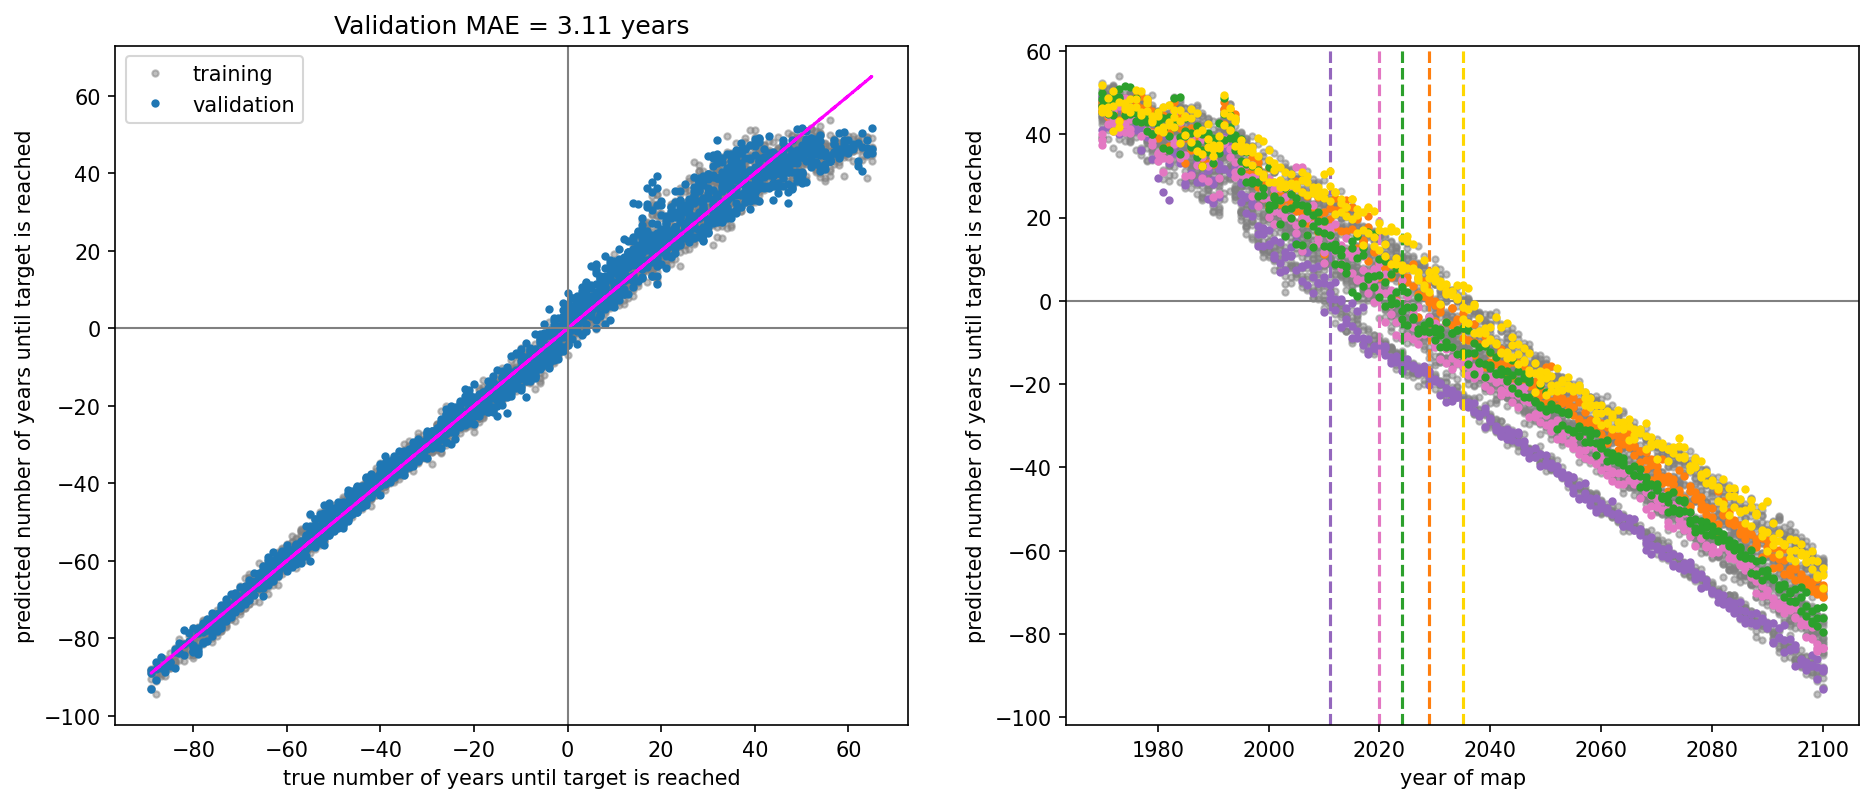

In [17]:
clr = ('tab:purple','tab:orange', 'tab:pink', 'tab:green', 'gold', 'violet','cornflowerblue','darkorange')
#--------------------------------
plt.subplots(1,2,figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(y_train, predict_train,'.',color='gray',alpha=.5, label='training')
plt.plot(y_val, predict_val,'.', label='validation')
plt.plot(y_val,y_val,'--',color='fuchsia')
plt.axvline(x=0,color='gray',linewidth=1)
plt.axhline(y=0,color='gray',linewidth=1)
plt.title('Validation MAE = ' + str(mae.round(2)) + ' years')
plt.xlabel('true number of years until target is reached')
plt.ylabel('predicted number of years until target is reached')
plt.legend()


plt.subplot(1,2,2)
plt.plot(y_yrs_train, predict_train,'.',color='gray',alpha=.5, label='training')
plt.xlabel('year of map')
plt.ylabel('predicted number of years until target is reached')
plt.axhline(y=0, color='gray', linewidth=1)

predict_val_mat = predict_val.reshape(N_GCMS,N_VAL,len(YEARS_UNIQUE))
for i in np.arange(0,predict_val_mat.shape[0]):
    plt.plot(YEARS_UNIQUE, predict_val_mat[i,:,:].swapaxes(1,0),'.', label='validation', color=clr[i])
    plt.axvline(x=target_years[i],linestyle='--',color=clr[i])
if IN_COLAB==False:
    pass
    # plt.savefig('figures/initial_result_seed' + str(SEED) + '.png', dpi=savefig_dpi)
plt.show()

## Explainability via Input * Gradient and Integrated Gradients
We will use two attribution explainaiblity methods called Input * Gradient and Integrated Gradients to make heatmaps of regions of the input that act as explanations for the network's prediction.

* https://keras.io/examples/vision/integrated_gradients/
* https://distill.pub/2020/attribution-baselines/

In [18]:
def plot_map(x, clim=None, title=None, text=None, cmap='RdGy'):
    plt.pcolor(x,
               cmap=cmap,
              )
    plt.clim(clim)
    plt.colorbar()
    plt.title(title,fontsize=15,loc='right')    
    plt.yticks([])
    plt.xticks([])
    
    plt.text(0.01, 1.0, text, fontfamily='monospace', fontsize='small', va='bottom',transform=plt.gca().transAxes)

In [19]:
#=========================================
# Define the samples you want to explain
rng = np.random.default_rng(45)
isubsample = rng.choice(np.arange(0,x_val.shape[0]),
                        size = 500,
                        replace = False,
                       )

inputs = np.copy(x_val[isubsample,:])
targets = np.copy(y_val[isubsample])
yrs = np.copy(y_yrs_val[isubsample])
preds = model.predict(inputs)

#=========================================
#---------------------------------------
# Gradient x Input
#---------------------------------------
# compute the multiplication of gradient * inputs
# and reshape into a map of latitude x longitude

grads = get_gradients(inputs,top_pred_idx).numpy()
grad_x_input = grads * inputs
grad_x_input = grad_x_input.reshape((len(targets),map_shape[0],map_shape[1]))
print(np.shape(grad_x_input))

#---------------------------------------
# Integrated Gradients
#---------------------------------------
baseline_mean = np.mean(x_train,axis=0)*0.    
print('shape(baseline_mean) = ' + str(np.shape(baseline_mean)))
print('model.predict(baseline_mean) = ' + str(model.predict(baseline_mean[np.newaxis,:])))

igrad = get_integrated_gradients(inputs, baseline=baseline_mean,top_pred_idx=top_pred_idx)
integrated_gradients = igrad.numpy().reshape((len(targets),map_shape[0],map_shape[1]))
print(np.shape(integrated_gradients))

(500, 72, 144)
shape(baseline_mean) = (10368,)
model.predict(baseline_mean) = [[45.256386]]
(500, 72, 144)


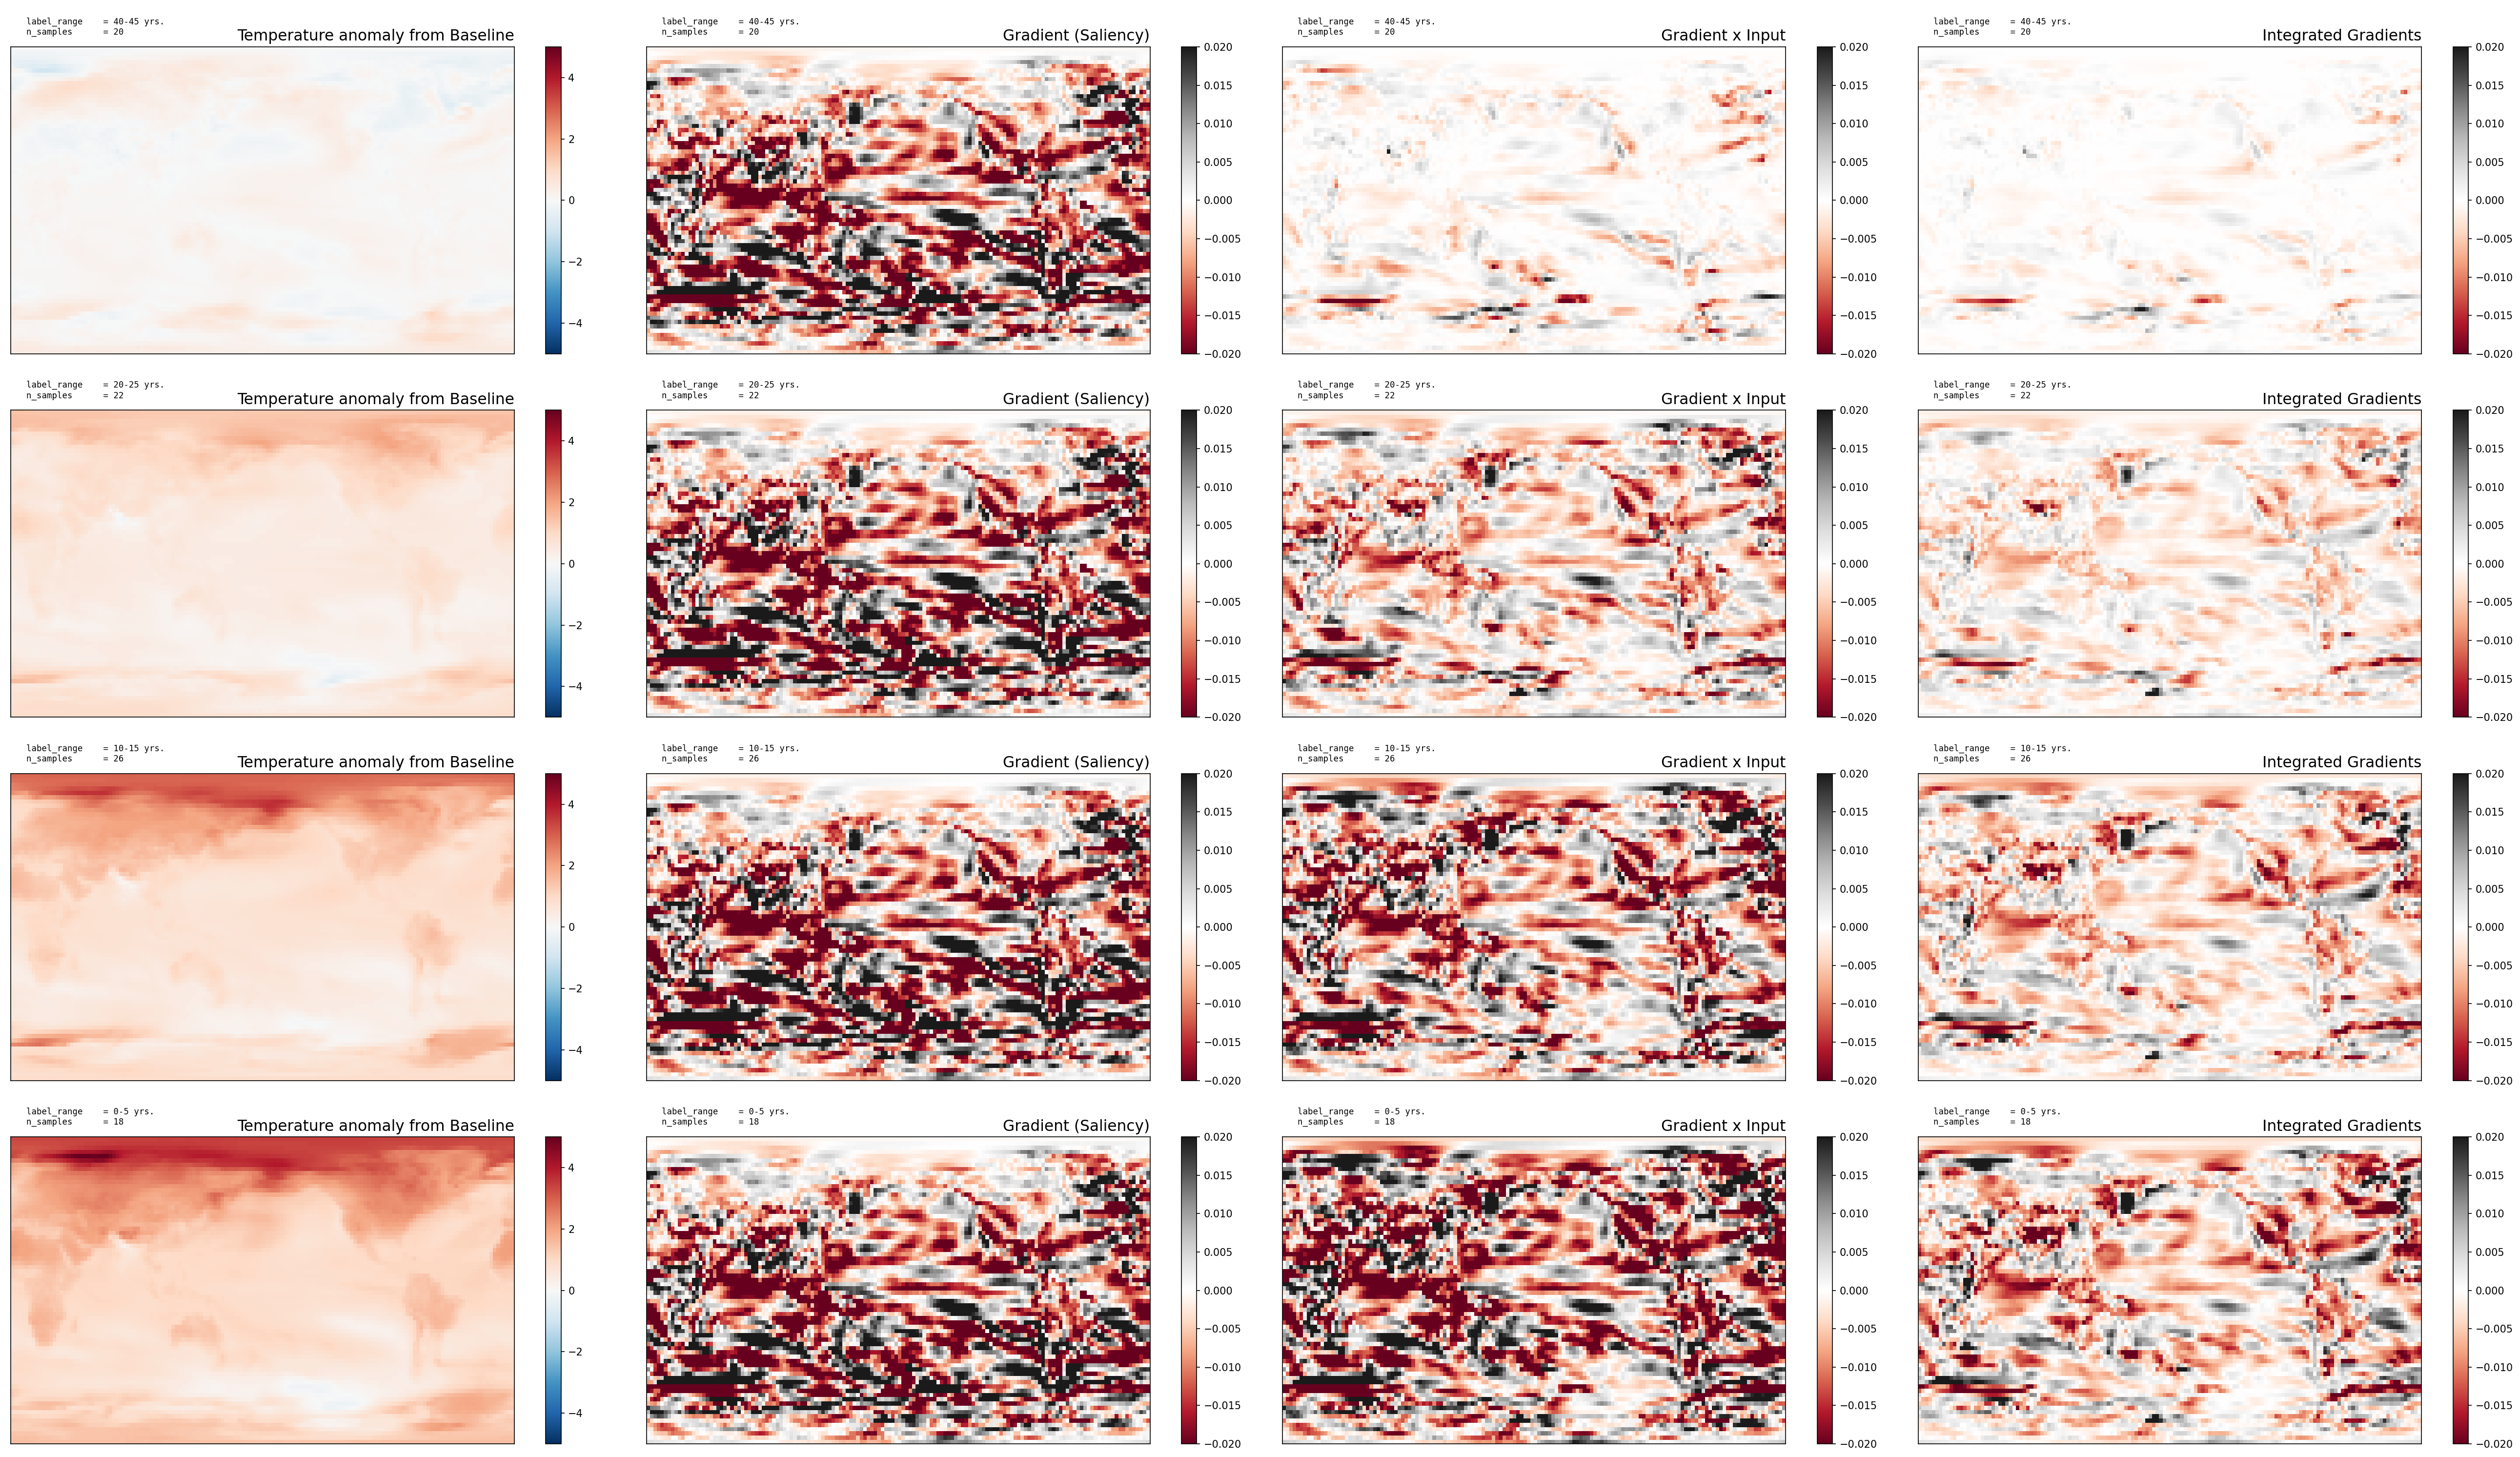

In [20]:

# plot the resulting heatmaps for a subset of samples
# based on their label
plot_list = (40, 20, 10, 0)
NCOL = 4
plt.subplots(len(plot_list),NCOL,figsize=(35,5*len(plot_list)))

for irow,min_range in enumerate(plot_list):
        
    max_range = min_range + 5
    isamples = np.where((targets >= min_range) & (targets <= max_range))[0]
    igrad_mean = np.mean(integrated_gradients[isamples,:,:],axis=0)
    grad_x_input_mean = np.mean(grad_x_input[isamples,:,:],axis=0)
    grad_mean = np.mean(grads[isamples,:],axis=0).reshape((map_shape[0],map_shape[1]))
    x_inputs_mean = np.mean(inputs[isamples,:],axis=0).reshape((map_shape[0],map_shape[1]))
    x_inputs_mean = x_inputs_mean - baseline_mean.reshape((map_shape[0],map_shape[1]))
    #------------------------------------------------------------------
    
    text = (
            "\n"
            + f"  label_range    = {min_range}-{max_range} yrs.\n"                    
            + f"  n_samples      = {len(isamples)}\n"
    )    
    #------------------------------------------------------------------    
    
    # plot average input map
    plt.subplot(len(plot_list),NCOL,irow*NCOL+1)
    plot_map(x_inputs_mean, 
             text=text,
             clim=(-5,5),
             cmap='RdBu_r',
             title = 'Temperature anomaly from Baseline',
            )
    #------------------------------------------------------------------
    # plot explainability of gradient (saliency)
    plt.subplot(len(plot_list),NCOL,irow*NCOL+2)
    plot_map(grad_mean, 
             text=text,             
             clim=(-0.02, .02), 
             title = 'Gradient (Saliency)',
            )
    
    #------------------------------------------------------------------
    # plot explainability of input x gradient
    plt.subplot(len(plot_list),NCOL,irow*NCOL+3)
    plot_map(grad_x_input_mean, 
             text=text,
             clim=(-.02,.02),
             title = 'Gradient x Input',
            )

    #------------------------------------------------------------------
    # plot explainability of integrated gradients
    plt.subplot(len(plot_list),NCOL,irow*NCOL+4)
    plot_map(igrad_mean, 
             text=text,             
             clim=(-.02,.02), 
             title = 'Integrated Gradients',
            )

plt.tight_layout()   
if IN_COLAB==False:
    pass
    # plt.savefig('figures/xai_grid_' + str(min_range) +'-' + str(max_range) + '_baseline_' + str(BASELINE) + '.png', dpi=savefig_dpi)
plt.show()



## Predict observations

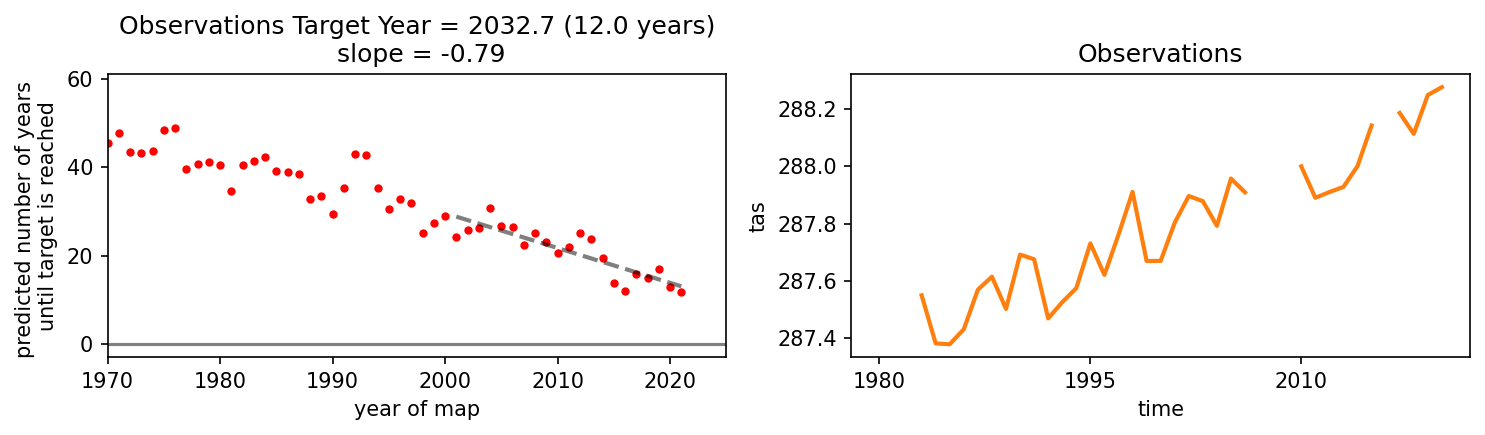

In [21]:
import scipy.stats as stats

if exp_settings["anomalies"]:
    x_obs_predict = np.nan_to_num(x_obs,0.)
y_predict_obs = model.predict(x_obs_predict)[:,top_pred_idx].flatten()

iy = np.where(da_obs['time.year'].values >= 2001)[0]
x = da_obs['time.year'].values[iy]
y = y_predict_obs[iy]
linear_model = stats.linregress(x=x,y=y)

#--------------------------------
i_year = np.where(y_predict_obs < 0)[0]
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(da_obs['time.year'], y_predict_obs, '.r')
plt.plot(x, linear_model.slope*x+linear_model.intercept, '--k', alpha=.5, linewidth=2)
plt.xlabel('year of map')
plt.ylabel('predicted number of years \nuntil target is reached')
plt.title('Observations Target Year = ' + 
          str(np.round(2021+y_predict_obs[-1],1)) +
          ' (' + str(y_predict_obs[-1].round()) + ' years)'+
          '\n slope = ' + str(linear_model.slope.round(2)) 
         )
plt.xlim(1970,2025)
# plt.ylim(-20,40)
plt.axhline(y=0,color='gray')

#--------------------------------
plt.subplot(1,2,2)
global_mean_obs.plot(linewidth=2,label='data',color="tab:orange")
plt.title('Observations')

plt.tight_layout()
plt.show()


np.shape(grads_obs) = (4, 10368)


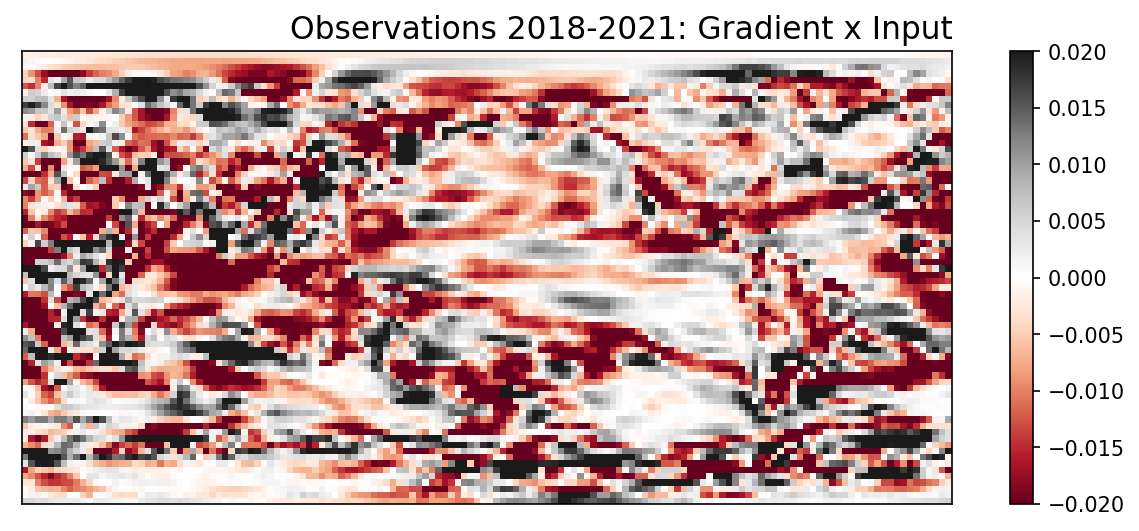

In [22]:
n_plot = 4
grads_obs = get_gradients(x_obs[-n_plot:,:],top_pred_idx=top_pred_idx).numpy()*x_obs[-n_plot:,:]
print('np.shape(grads_obs) = ' + str(np.shape(grads_obs)))
grads_obs_mean = np.mean(grads_obs,axis=0)
plt.figure(figsize=(10,4))
plot_map(grads_obs_mean.reshape((map_shape[0],map_shape[1])), 
         clim = (-.02,.02),
         title = 'Observations ' + str(2021-n_plot+1) + '-' + str(2021) + ': Gradient x Input',
        )

In [23]:
import scipy.stats as stats
import seaborn as sns

if exp_settings["network_type"] == 'shash2':

    clr_choice = 'orange'
    y_predict_obs = model.predict(x_obs_predict)

    iy = np.where(da_obs['time.year'].values >= 2011)[0]
    x = da_obs['time.year'].values[iy]
    y = y_predict_obs[iy,0]
    linear_model = stats.linregress(x=x,y=y)

    #--------------------------------
    norm_incs = np.arange(-80,80,1)
    mu_pred = y_predict_obs[:,0]
    sigma_pred = y_predict_obs[:,1]
    norm_dist = tfp.distributions.Normal(mu_pred,sigma_pred)
    norm_perc_low = norm_dist.quantile(.25).numpy()   
    norm_perc_high = norm_dist.quantile(.75).numpy()      
    norm_perc_med = norm_dist.quantile(.5).numpy()      
    norm_cpd = norm_dist[-1].prob(norm_incs)
    y_predict_obs = norm_perc_med
    
    print('2021 prediction = ' + str(mu_pred[-1]) + ' (' + str(norm_perc_low[-1]) + ' to ' + str(norm_perc_high[-1]) + ')')

    #------------------------------------------------------------
    ax = plt.subplots(1,2,figsize=(16,4))
    years = np.arange(1850,2022)

    plt.subplot(1,2,1)
    for iyear in np.arange(0,y_predict_obs.shape[0]):
        min_val = norm_perc_low[iyear]
        max_val = norm_perc_high[iyear]

        if(years[iyear]==2021):
            clr = clr_choice
        else:
            clr = 'gray'
        plt.plot((years[iyear],years[iyear]),(min_val, max_val),
                 linestyle='-',
                 linewidth=4,
                 color=clr,
                )

    plt.plot(x,x*linear_model.slope+linear_model.intercept,'--', color='black')

    plt.xlim(1970.5,2023)    
    plt.ylim(0,57)
    plt.ylabel('years until target')
    plt.xlabel('year')
    plt.title('Observations predictions under SSP337 (norm)\n slope=' + str(linear_model.slope.round(2)))

    plt.subplot(1,2,2)
    plt.plot(norm_incs,norm_cpd,
             linewidth=5,
             color=clr_choice,
            )

    k = np.argmin(np.abs(norm_perc_low[-1]-norm_incs))
    plt.plot((norm_perc_low[-1],norm_perc_low[-1]),(0,norm_cpd[k]),'--',color=clr_choice)
    k = np.argmin(np.abs(norm_perc_high[-1]-norm_incs))
    plt.plot((norm_perc_high[-1],norm_perc_high[-1]),(0,norm_cpd[k]),'--',color=clr_choice)

    plt.xlabel('years until target')
    plt.title('Predictions for Observations\nYear = 2021')
    plt.xlim(-10,40)
    plt.tight_layout()
    plt.show()